<a href="https://colab.research.google.com/github/AnIsAsPe/Aprendizaje-por-Refuerzo/blob/main/Notebooks/Deep_QLearning_Gesti%C3%B3n_de_una_red_el%C3%A9ctrica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# El Problema

## Red eléctirca "El Espino"

---
![microgrid Espino](https://ars.els-cdn.com/content/image/1-s2.0-S0360544219317682-gr4.jpg)

---

**Objetivo:**

 Optimizar el ***costo*** de la red frente a la incertidumbre de la generación de energía solar y de la demanda de energía

**Alternativas:**

1. Operar la red con reglas:

    - Priorizar consumo de la energía solar
    - Si la generación fotovoltaica es mayor que la demanda, se carga la batería
    - Si la energía solar no alcanza a satisfacer el consumo, se descarrga la batería hasta que alcance el 50% de la carga
    - Si la energía solar y la batería no alcanzan a satisfacer la demanda, se prende el generador de gas
    - El generador carga la batería si la demanda es menor que la generación minima de operación.

2. Aprender una ***política*** que optimize los costos de la red y guíe la elección de una acción dado un estado

Necesitamos definir las ***acciones posibles*** y los ***estados posibles*** y realizar un proceso de aprendizaje de la política

## Estados, acciones, recompensa/pérdida

**Acciones posibles:**

- Generar energía con gas
- Descargar batería para usar energía almacenada
- Cargar batería (almacenar exceso de energía)

**Estados posibles:**

- Demanda Neta:  Demanda de energía - Generación de energía solar
- Estado de carga de la Batería


**Recompensa/pérdida**
- Costo de generación de electricidad

# Bibliotecas

[pymgrid](https://github.com/Total-RD/pymgrid)


In [ ]:
!pip install https://raw.githubusercontent.com/AnIsAsPe/Aprendizaje-por-Refuerzo/main/pymgrid-0.1.0-beta_modified_.zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00
  Created wheel for pymgrid: filename=pymgrid-0.1.0-py3-none-any.whl size=3425262 sha256=699b728b70bd0fdb3d0c91558bd195567ffde1f99e01e90d9338e31ab5eb154c
  Stored in directory: /root/.cache/pip/wheels/4c/8e/ee/01e10fd5a1730e59d749f2baf4ec833c5efcf1d4ba0d7bf6b6
Successfully built pymgrid


In [ ]:
from pymgrid import MicrogridGenerator as mg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import sys
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ambiente:
* Arquitectura de la microrred
* Datos históricos de demanda energética y generación solar
* Componentes de la red

In [ ]:
# # seleccionamos un ambiente con un arquitectura conveniente para nuestro problema
# env = mg.MicrogridGenerator(nb_microgrid=100,
#                             random_seed = 2  # el tamaño de los componente de la red es asignado aleatoriamente
#                             )
# env.generate_microgrid(verbose=False)

# red = env.microgrids[37]

# # Para asegurar la reproducibilidad del código guardamos la red como objeto pickle

# path = '/content/drive/MyDrive/Modelos/Política Red Electrica/'

# pickle.dump(red, open(path + "red2025.pkl", "wb"))

### Lectura y revisión arquitectura de la microrred

In [ ]:
# Para asegurar la reproducibilidad del código usaremos la red guardada como objeto pickle

path = '/content/drive/MyDrive/Modelos/Política Red Electrica/'

red = pickle.load(open(path + "red2025.pkl", "rb"))

red.reset()

In [ ]:
 red.print_info()

Microgrid parameters


,load,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,...,battery_cost_cycle,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,1603,10,1,0.1,1667.12,0.205436,826,826,3303,0.9,...,0.02,3,4.893013,0.26072,0.040264,1782,0.05,0.9,0.4,2


Architecture:
{'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}
Actions: 
dict_keys(['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset'])
Control dictionnary:
['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset']
Status: 
dict_keys(['load', 'hour', 'pv', 'battery_soc', 'capa_to_charge', 'capa_to_discharge'])
Has run mpc baseline:
False
Has run rule based baseline:
False


Cada acción(`Action`) que se aplique a la red será definida por los valores que se pasen a cada una de las claves del diccionario de control.
Cuando se aplique la acción, entonces obtendremos un `Status` nuevo.

### Datos históricos de demanda energética y generación solar

Cada observación es una hora y la longitud de la serie es de un año (8769 horas)

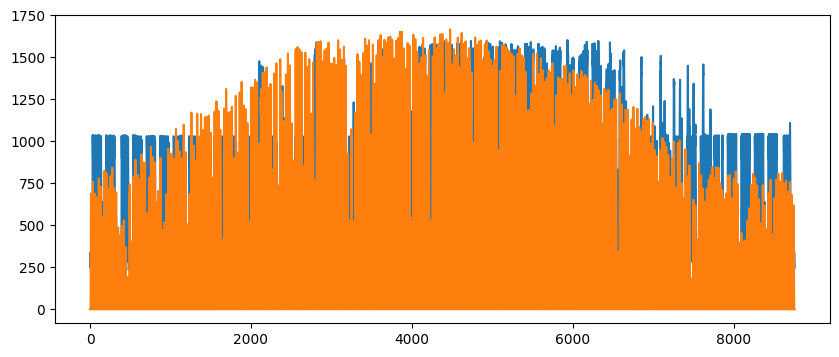

In [ ]:
red.set_horizon(8769)   # se pueden hacer predicciones hasta por un año: 8769 horas

plt.figure(figsize=(10,4))
plt.plot(red.forecast_load(), label='load')
plt.plot(red.forecast_pv(), label='pv')

## Características de los componentes


**Demanda**

In [ ]:
 # Variable aleatoria en función del tiempo
red.load

np.float64(1123.5340050262632)

**Generación fotovoltaica (pv)**

In [ ]:
# variable aleatoria en función del tiempo
red.pv

np.float64(0.0)

**Batería**

In [ ]:
## Costante. Cantidad de energía máxima que puede cargar la batería en una hora
red.battery.p_charge_max


np.int64(826)

In [ ]:
# Constante. Cantidad de energía máxima que puede descargar la batería en una hora
red.battery.p_discharge_max

np.int64(826)

In [ ]:
# Constante. Estado de carga máxima
red.battery.soc_max

np.int64(1)

In [ ]:
# Constante. Estado de carga mínima
red.battery.soc_min

np.float64(0.2)

In [ ]:
# Variable. Estado de la carga
red.battery.soc

np.float64(0.9753801220904987)

In [ ]:
# Variable dependiente de soc. Cantidad de energía que la batería puede cargar antes de tener carga completa
red.battery.capa_to_charge

np.float64(90.35495192786965)

In [ ]:
# Variable dependiente de soc. Cantidad de energía disponible antes de estar totalmente descargada
red.battery.capa_to_discharge

np.float64(2304.972488938426)

**Generador de combustibles fósiles (genset)**

In [ ]:
# Características del generador
print('Costo del combustible por KWh: ${:0.2f} '.format(red.genset.fuel_cost))
print('Potencia máxima en KW: ', red.genset.rated_power )
print('Operación mínima y máxima: {}%, {}%'.format(red.genset.p_min,
                                                         red.genset.p_max))

Costo del combustible por KWh: $0.40 
Potencia máxima en KW:  1782
Operación mínima y máxima: 0.05%, 0.9%


In [ ]:
red.genset.p_min*red.genset.rated_power

np.float64(89.10000000000001)

Con los valores anteriores podemos calcular la potencia en KW máxima y mínima de operación

In [ ]:
gen_min = red.genset.p_min * red.genset.rated_power  #potencia mínima del generador
gen_max = red.genset.p_max * red.genset.rated_power  #potencia maxima del generador
gen_min, gen_max

(np.float64(89.10000000000001), np.float64(1603.8))

## Diccionario de control para interactuar con la red

La función `run()` necesita un diccionatrio de control que depende de la arquitectura de nuestra red,  con el que indicaremos las acciones en cada momento.


In [ ]:
# Los campos que se pueden usar en el diccionario de control de nuestra red para establecer las acciones son:
red.get_control_dict()

['load',
 'pv_consummed',
 'pv_curtailed',
 'pv',
 'battery_charge',
 'battery_discharge',
 'genset']

`load` y `pv`, se cargan automáticamente.

Nosotros nos concentraremos en si se carga la batería, si se descarga o si se genera energía con fuentes fósiles


In [ ]:
# red.reset()
demanda_neta = red.load - red.pv
print('Estado: ({}, {})\n'.format(demanda_neta, red.battery.soc))

#con los valores del diccionario vamos a establecer la acción a tomar
accion = {
            'pv_consumed': 0,
            'pv_curtail':0,
            'battery_charge':5000 ,
            'battery_discharge':0,
            'genset': 0
          }

red.run(accion)    # Nos regresa un diccionario con un nuevo estatus.


Estado: (1123.5340050262632, 0.9753801220904987)



{'load': np.float64(250.4811057482691),
 'hour': 0,
 'pv': np.float64(0.0),
 'battery_soc': np.float64(2.3377779422539864),
 'capa_to_charge': 0,
 'capa_to_discharge': np.float64(6354.972488938425)}

Corre las dos celdas de código varias veces y observa los resultados

# Definición de las acciones

* accion 0: cargar batería
* accion 1: descargar batería
* acción 2: generación no renovable (genset)

In [ ]:
def obten_dicionario_control(id_accion):
    '''  Crea el diccionario para interactuar con la red según la acción tomada:
    0: Cargar batería. La energía a cargar, depende de las variables de estado
    1: Descargar batería.
    2.: Generar energía no renovable (genset).

    Para cualquier de estas acciones es necesario identificar cuanta energía esta
    disponible o cuánta se está demandando a la red, a través de la demanda neta;
    Además es necesario evaluar cuánta energía puede cargarse o descargarse al
    momento de la acción.
    '''

    demanda_neta =  red.load - red.pv
    # Energía que se puede cargar en la batería:
    p_charge = max(0,    # Debe ser mayor a cero
                   min(-demanda_neta + gen_min,    # energía disponible, en el tiempo t
                       red.battery.capa_to_charge, # energía por cargar, antes de tener carga máxima, en el tiempo t
                       red.battery.p_charge_max    # energía que puede cargarse por hora
                       )
                   )

    # Energía que se puede descargar de la batería
    p_discharge = max(
                      0,
                      min(
                          demanda_neta-gen_min,   # energía faltante para cubrir la demanda, en el tiempo t
                          red.battery.capa_to_discharge, # energía disponible, antes de tener carga mínima, en el tiempo t
                          red.battery.p_discharge_max  #  energía que puede descargarse en una hora
                          )
                      )

    control_dic ={}
    if id_accion == 0:   # Cargar batería
        control_dict= {'pv_consumed': min(red.pv, red.load),
                       'pv_curtailed':0,
                       'battery_charge': p_charge,
                       'battery_discharge': 0,
                       'genset': gen_min
                       }
    elif id_accion == 1:   # Descargar bateria
        control_dict = {'pv_consummed': min(red.pv, red.load-p_discharge),
                        'pv_curtailed':0,
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'genset': gen_min
                        }

    elif id_accion == 2:  #Generación no renovable (genset)
        p_genset = max(gen_min,
                       min(gen_max,
                           max(0, demanda_neta)))
        control_dict = {'pv_consummed': min(red.pv, red.load-p_genset),
                        'pv_curtailed':0,
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'genset': p_genset
                       }
    return control_dict

In [ ]:
red.reset()  # reiniciar el entorno
print('** Tiempo t **:')
print('load: {0:.2f}, pv: {1:.1f}, battery_soc: {2:.1f}'.format(red.load, red.pv, red.battery.soc))

# Elegir una acción
id_accion = 0
dict_control = obten_dicionario_control(id_accion)

# Interactuar con la red con la acción elegida
red.run(dict_control)
print('\nDiccionario para interactuar con la red:\n',dict_control)

print('\n** Tiempo t+1 **:')
print('load: {0:.2f}, pv: {1:.1f}, battery_soc: {2:.3f}'.format(red.load, red.pv, red.battery.soc))
print('\nCOSTO DE LA ACCIÓN: ${:.2f} '.format(red.get_cost()))

** Tiempo t **:
load: 713.72, pv: 0.0, battery_soc: 0.3

Diccionario para interactuar con la red:
 {'pv_consumed': np.float64(0.0), 'pv_curtailed': 0, 'battery_charge': 0, 'battery_discharge': 0, 'genset': np.float64(89.10000000000001), 'load': np.float64(713.7249926298446), 'pv': np.float64(0.0)}

** Tiempo t+1 **:
load: 566.87, pv: 0.0, battery_soc: 0.307

COSTO DE LA ACCIÓN: $6299.71 


# Normalización de los estados

In [ ]:
red.reset()
red.set_horizon(8769)
min_demanda_neta = (red.forecast_load() - red.forecast_pv()).min()
max_demanda_neta = (red.forecast_load() - red.forecast_pv()).max()
min_demanda_neta, max_demanda_neta

(np.float64(-1431.6297206874096), np.float64(1495.58245322938))

In [ ]:
def normaliza_estado(demanda_neta, soc):

    # Calculamos el valor mínimo y máximo de la demanda neta para el ohorizonte dado
    red.reset()
    red.set_horizon(8769)
    min_demanda_neta = (red.forecast_load() - red.forecast_pv()).min()
    max_demanda_neta = (red.forecast_load() - red.forecast_pv()).max()

    # Normalización min-max para demanda_neta
    normalized_demanda_neta = (demanda_neta - min_demanda_neta) / \
                              (max_demanda_neta - min_demanda_neta)
    # soc ya está en [0, 1], solo lo pasamos
    normalized_soc = soc

    return np.array([normalized_demanda_neta, normalized_soc])

normaliza_estado(demanda_neta, red.battery.soc)

array([0.87290007, 0.44204333])

# Deep Q Learning


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import random
from collections import deque
import sys


### Memoria

Nos permitirá guardar registros de experiencias (estado, accion, recompensa, siguiente estado) que serán usadas en el entrenamiento.

In [ ]:
class ReplayBuffer:
    """
    Esta memoria guarda muestras de estado, acción, recompenza y el siguiente
    estado para ser usadas durante el entrenamiento.
    """
    def __init__(self, capacity):
        # Inicializa la memoria estableciendo su capacidad máxima
        self.buffer = deque(maxlen=capacity)

    def store_experience(self, state, action, reward, next_state):
        # Almacena una tupla de experiencia en el buffer
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        # Muestra aleatoriamente un lote de experiencias del buffer
        # return random.sample(self.buffer, batch_size) # Removed the commented out code
        state, action, reward, next_state = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)


    def __len__(self):
        # Retorna el número actual de experiencias en el buffer
        return len(self.buffer)

### DQN Agent

El agente es el encargado de elegir la acción para cada estado.
En la fase de entrenamiento su objetivo será aprender la política que minimice el costo de operación de la red usando aprendizaje profundo (redes neuronales)

In [ ]:

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_rate=0.995, target_update_freq=10):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_rate = epsilon_decay_rate
        self.target_update_freq = target_update_freq

        self.memory = ReplayBuffer(capacity=10000)  # Inicializamos la memoria
        self.t_step = 0 # Para contar las actualizaciones de los pesos de q_network y saber cuándo actualizar target_q_network


        #--- CONSTRUCCIÓN DE LA ARQUITECTURA DE LAS REDES NEURONALES ----
        # ** Q-Network ** (Actualización constante)
        self.q_network = self._build_model()

        # ** Target Q-Network** (idéntica a la anterior pero se actualiza con menos frecuencia)
        self.target_q_network = self._build_model()
        self.target_q_network.set_weights(self.q_network.get_weights()) # Se inicializa con los mismos pesos que q_network

        #--- OPTIMIZADOR ---
        self.optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        #--- FUNCIÓN DE PÉRDIDAD ---
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def _build_model(self):
        """
        Arquitectura de una rnn para aproximar el valor Q para cada acción dado un estado.
        """
        model = models.Sequential()
        model.add(layers.Input(shape=(self.state_size,))) # La entrada es un estado del entorno (DemandaNeta, soc)
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear')) # La salida es el valor de Q para cada posible acción
        return model

    # APRENDIZAJE
    def learn(self, batch_size):
        '''
        Es el ciclo principal de aprendizaje del agente
        '''
        if len(self.memory) < batch_size:
            return
        # Toma una muestra de experiencias desde la memoria y los convierte en tensores
        states, actions, rewards, next_states = self.memory.sample(batch_size)

        states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        actions_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards_tensor = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states_tensor = tf.convert_to_tensor(next_states, dtype=tf.float32)

        with tf.GradientTape() as tape:
            # Calcula el valor Q para todas las acciones posibles en el estado actual
            q_values = self.q_network(states_tensor)
            # Se queda con el valor Q de la acción elegida
            q_value_taken = tf.gather_nd(q_values, tf.stack([tf.range(batch_size), actions_tensor], axis=1))

            # Obtiene el valor de Q del siguiente estado para la acción mejor evaluada anteriormente para ese estado
            next_q_values_target = self.target_q_network(next_states_tensor)
            max_next_q_value = tf.reduce_max(next_q_values_target, axis=1)

            # Calcula el target de Q_value
            target_q_value = rewards_tensor + self.gamma * max_next_q_value

            # Calcula la pérdida
            loss = self.loss_fn(target_q_value, q_value_taken)

        # Calcula los gradientes y los aplica para actualizar los pesos de q_network
        gradients = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.q_network.trainable_variables))

        # Actualiza también (algunas veces) la target_q_network
        self.t_step += 1
        if self.t_step % self.target_update_freq == 0:


    def update_target_model(self):
        # Actualiza los pesos de la red target_q_network con los pesos de la red q_network
        self.target_q_network.set_weights(self.q_network.get_weights())

    def select_act(self, state):
        '''
        Selecciona la acción para cada estado ya sea por exploración o explotación.
        '''
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.q_network.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_values[0])




In [ ]:
# Instantiate the DQN Agent
agent = DQNAgent(state_size=2, action_size=3,
                 learning_rate=0.001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.005,
                 epsilon_decay_rate=0.9975, target_update_freq=72)

0.006695896276803789
[0.9975, 0.9950062500000001, 0.9925187343750002, 0.9900374375390627, 0.9875623439452151, 0.9850934380853521, 0.9826307044901388, 0.9801741277289134, 0.9777236924095912, 0.9752793831785673, 0.972841184720621, 0.9704090817588195, 0.9679830590544225, 0.9655631014067865, 0.9631491936532696, 0.9607413206691364, 0.9583394673674637, 0.9559436186990451, 0.9535537596522975, 0.9511698752531668, 0.9487919505650338, 0.9464199706886213, 0.9440539207618998, 0.9416937859599951, 0.9393395514950952, 0.9369912026163575, 0.9346487246098166, 0.9323121027982921, 0.9299813225412964, 0.9276563692349432, 0.9253372283118559, 0.9230238852410764, 0.9207163255279738, 0.9184145347141539, 0.9161184983773686, 0.9138282021314252, 0.9115436316260968, 0.9092647725470315, 0.906991610615664, 0.9047241315891249, 0.9024623212601521, 0.9002061654570018, 0.8979556500433594, 0.8957107609182511, 0.8934714840159556, 0.8912378053059157, 0.8890097107926509, 0.8867871865156693, 0.8845702185493802, 0.8823587930

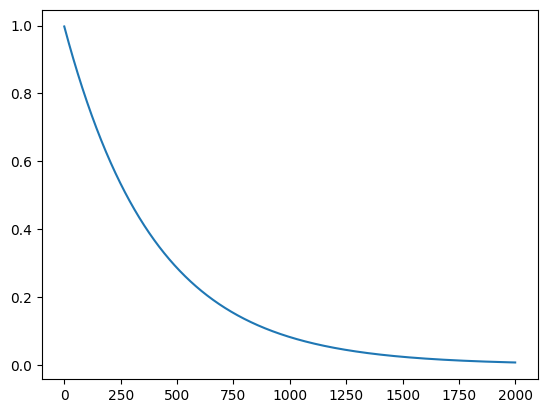

In [ ]:
e = 1
epsilons=[]
total_episodios = 2000
for episodio in range(total_episodios):
    e = e * 0.9975
    epsilons.append(e)
print(e)
print(epsilons)
plt.plot(epsilons)

### Entrenamiento del agente

In [ ]:
def train_dqn(env, agent, n_episodes=2000, max_t=24, batch_size=64, print_every=100):
    """
    Trains a Deep Q-Learning agent in the given environment.

    Args:
        env: The microgrid environment (e.g., 'red' object from pymgrid).
        agent: The DQNAgent instance.
        n_episodes (int): Maximum number of training episodes.
        max_t (int): Maximum number of timesteps per episode.
        batch_size (int): Size of the mini-batch for learning.
        print_every (int): How often to print training progress.
    """
    scores = []
    scores_window = deque(maxlen=print_every)

    for i_episode in range(1, n_episodes + 1):
        env.reset()
        # Se obtiene el estado actual
        demanda_neta = env.load - env.pv
        soc = env.battery.soc
        state = normaliza_estado(demanda_neta, soc)

        episode_cost = 0 # Inicializamos el costo de cada episodio
        for t in range(max_t):

            # El agente elige la acción
            id_accion = agent.select_act(state)
            accion_dic = obten_dicionario_control(id_accion)

            # Aplicamos la acción elegida al ambiente
            env.run(accion_dic)

            # Obtenemos el costo de la acción y el siguiente estado
            reward = -env.get_cost()
            demanda_neta = env.load - env.pv
            soc = env.battery.soc
            next_state = normaliza_estado(demanda_neta, soc)

            # Guardamos en la memoria el estado, la acción aplicada, la recompensa y el siguiente estado
            agent.memory.store_experience(state, id_accion, reward, next_state)

            # Entenamos la red neuronal
            agent.learn(batch_size)

            # Sumamos el costo de esa acción al costo total del episodio
            episode_cost -= reward

            state = next_state

        # Actualizamos el valor de epsilón para el siguiente episodio
        if agent.epsilon > agent.epsilon_end:
            agent.epsilon *= agent.epsilon_decay_rate

        # Imprimimos los costos obtenidos
        scores_window.append(episode_cost)
        scores.append(episode_cost)

        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Cost: {np.mean(scores_window):.2f}\tEpsilon: {agent.epsilon:.3f}')
    return scores

Starting DQN training...
Episode 100	Average Cost: 27289.84	Epsilon: 0.779
Episode 200	Average Cost: 24105.87	Epsilon: 0.606
Episode 300	Average Cost: 19397.53	Epsilon: 0.472
Episode 400	Average Cost: 15159.35	Epsilon: 0.367
Episode 500	Average Cost: 13905.58	Epsilon: 0.286
Episode 600	Average Cost: 11307.82	Epsilon: 0.223
Episode 700	Average Cost: 10033.17	Epsilon: 0.173
Episode 800	Average Cost: 8998.54	Epsilon: 0.135
Episode 900	Average Cost: 8229.55	Epsilon: 0.105
Episode 1000	Average Cost: 7646.08	Epsilon: 0.082
Episode 1100	Average Cost: 7676.55	Epsilon: 0.064
Episode 1200	Average Cost: 7028.73	Epsilon: 0.050
Episode 1300	Average Cost: 6802.40	Epsilon: 0.039
Episode 1400	Average Cost: 6446.17	Epsilon: 0.030
Episode 1500	Average Cost: 6499.40	Epsilon: 0.023
Episode 1600	Average Cost: 6703.61	Epsilon: 0.018
Episode 1700	Average Cost: 6258.79	Epsilon: 0.014
Episode 1800	Average Cost: 6037.70	Epsilon: 0.011
Episode 1900	Average Cost: 6297.75	Epsilon: 0.009
Episode 2000	Average Cost: 

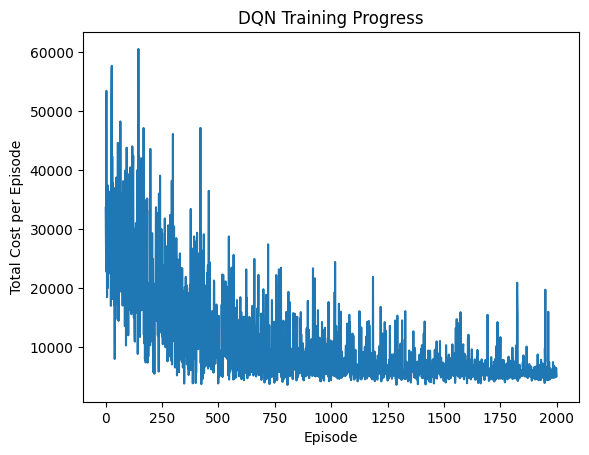

CPU times: user 1h 26min 8s, sys: 1min 50s, total: 1h 27min 59s
Wall time: 1h 31min 57s


In [ ]:

%%time
print("Starting DQN training...")
episode_costs = train_dqn(env=red, agent=agent,
                          n_episodes=2000, # Adjust number of episodes
                          batch_size=64,
                          print_every=100)

print("Training finished.")

plt.plot(episode_costs)
plt.xlabel('Episode')
plt.ylabel('Total Cost per Episode')
plt.title('DQN Training Progress')
plt.show()

# Guardamos los pesos del modelo entrenado

In [1]:
# Guardamos los pesos

q_network_weights_path = "/content/drive/MyDrive/Modelos/Política Red Electrica/dqn_q_network_weights.weights.h5"
target_q_network_weights_path = "/content/drive/MyDrive/Modelos/Política Red Electrica/dqn_target_q_network_weights.weights.h5"

agent.q_network.save_weights(q_network_weights_path)
agent.target_q_network.save_weights(target_q_network_weights_path)


En el futuro, podemos crear una instancia nueva del agente donde actualicemos los pesos entrenados para seguir mejorando el modelo o simplemente crear una  red neuronal identica  a q_network con la misma arquitectura  (capas, unidades...) a la que asignar los pesos entrenados para obtener el  valor de cada acción dada cualquier estado.

In [ ]:

# loaded_agent = DQNAgent(state_size=2, action_size=3)

# loaded_agent.q_network.load_weights(q_network_weights_path)
# loaded_agent.target_q_network.load_weights(target_q_network_weights_path)
